# Praca domowa 02, grupa walidacyjna
## Laura Hoang, Piotr Bielecki

Tematem tej pracy domowej jest przeprowadzenie klasyfikacji zbioru danych `allegro-api-transaction`.
Celem naszej grupy jest walidacja pracy grupy nr.6 (Wiktor Jakubowski, Grzegorz Zbrzeżny). Komentarze w kodzie drugiej grupy są zapisane *czcionką pochyłą*.

## Budowa (fragment drugiej grupy):

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

C:\Users\laura\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("allegro-api-transactions.csv")

In [3]:
data.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


# Identyfikacja zmiennej celu

Naszą zmienną celu jest `price`. Do jej identyfikacji na pewno nie będziemy potrzebowali kolumn `lp`, gdyż jest ona unikalna dla każdego rekordu oraz `item_id`, gdyż dla znacznej większości rekordów jet ona unikalna

In [4]:
data.drop(["lp", "item_id"], axis = 1, inplace = True)

*Komentarz: Słuszny krok. Identyfikatory nie wnoszą nam potrzebnych informaccji.*

# Podział danych

Dodamy kolumnę `second_category`, która przyda się później, a ponadto usuniemy kolumnę `date`, gdyż dane dotyczą jedynie jednego dnia, a godziny o których wstawiono ogłoszenie właściwie nie mają wpływu na wartość `price`. Dodatkowo wiele rekordów jest zduplikowanych nie uwzględniając kolumny `date`, więc je także powinniśmy usunąć przed podziałem.

In [5]:
data.drop('date', axis = 1, inplace = True)

In [6]:
data = data.drop_duplicates().reset_index(drop = True)

In [7]:
df = data.copy()
df['second_category'] = df['categories'].apply(lambda x: x.split("'")[3])
y = df["price"].copy()
X = df.drop("price", axis = 1)

Podzielmy dane na próby:
* `treningowa - 60% danych`
* `testowa - 20% danych`
* `walidacyjna - 20% danych`

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2, random_state = 42, shuffle = True)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 42, shuffle = True)

`X_val` i `y_val` to dane, na któych będzie pracować zespół walidacyjny.

Przeprowadziliśmy preprocessing oddzielnie dla zbioru testowego i treningowego

# Preprocessing danych treningowych

Dla ułatwienia preprocessingu połączymy `X_train` z `y_train`.

In [9]:
data = X_train.join(y_train)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196152 entries, 15244 to 155113
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   categories              196152 non-null  object 
 1   pay_option_on_delivery  196152 non-null  int64  
 2   pay_option_transfer     196152 non-null  int64  
 3   seller                  196152 non-null  object 
 4   it_is_allegro_standard  196152 non-null  int64  
 5   it_quantity             196152 non-null  int64  
 6   it_is_brand_zone        196152 non-null  int64  
 7   it_seller_rating        196152 non-null  int64  
 8   it_location             196152 non-null  object 
 9   main_category           196152 non-null  object 
 10  second_category         196152 non-null  object 
 11  price                   196152 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 23.5+ MB


Widzimy, że nie ma braków danych oznaczonych nullami, czy NA. Sprawdźmy jeszcze, czy nie występują braki danych oznaczone innymi, popularnymi znakami.

In [11]:
x = []
for col in data:
    x.append(data[data[col].isin(["?", -1, "Unknown", "unknown", ""])].shape[0])

In [12]:
x

[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0]

Mamy 3 rekordy w którym mamy brak danych w kolumnie `it_seller_rating`. Jest on oznaczony -1. Jako, że są to trzy rekordy ze 326922 możemy go po prostu usunąć.

In [13]:
data = data[data["it_seller_rating"] != -1]

*Komentarz: Dobrze, słusznie zostały pominięte te wiersze.*

Usuńmy kolumnę `seller`, gdyż przy identyfikacji `price` o wiele bardziej obchodzić nas będzie `rating` sprzedającego niż tylko jego pseudonim.

In [14]:
data.drop("seller", axis = 1, inplace = True)

Sprawdźmy decyle w kolumnie `it_quantity`, ponieważ chcemy ją encodować na 4 kategorie.

In [15]:
np.percentile(data["it_quantity"], [i for i in range(10, 110, 10)])

array([0.0000e+00, 2.0000e+00, 8.0000e+00, 2.2000e+01, 6.2000e+01,
       1.6600e+02, 6.7300e+02, 9.5500e+02, 9.9800e+02, 9.9999e+04])

In [16]:
def encode_quant(x):
    if x < 9:
        return 0
    elif x < 100:
        return 1
    elif x < 900:
        return 2
    else: return 3

In [17]:
data["it_quantity"] = data["it_quantity"].apply(encode_quant)

Sprawdźmy decyle w kolumnie `it_seller_rating`, ponieważ chcemy ją encodować na 3 kategorie.

In [18]:
np.percentile(data["it_seller_rating"], [i for i in range(10, 110, 10)])

array([   309. ,    951. ,   2067.4,   3663. ,   6066. ,   9653. ,
        14912. ,  25139. ,  49591. , 292073. ])

In [19]:
def seller_rating_encode(x):
    if x < 2500:
        return 0
    elif x < 16500:
        return 1
    else: return 2

In [20]:
data["it_seller_rating"] = data["it_seller_rating"].apply(seller_rating_encode)

Sprawdźmy decyle w kolumnie `price`, ponieważ chcemy ją encodować na 3 kategorie.

In [21]:
np.percentile(data["price"], [i for i in range(10, 110, 10)])

array([3.450e+00, 6.990e+00, 1.190e+01, 1.799e+01, 2.500e+01, 3.549e+01,
       5.400e+01, 8.900e+01, 1.690e+02, 1.190e+05])

W poniższej funkcji:
* `0 - cena niska`
* `1 - cena średnia`
* `2 - cena wysoka`

W naszym modelu nie będzimy patrzyli na kategorię produktu w przypadku skategoryzowania go pod kątem ceny. To znaczy, że na przykład wsszelkie produkty poniżej 200 PLN, a powyżej 20 PLN zakwalifikujemy do kategorii 1, nie patrząc na to, czy jest to na przykład skarpetka, czy telefon. 

In [22]:
def encode_price(x):
    if x < 20:
        return 0
    elif x < 200:
        return 1
    else: return 2

In [23]:
data["price"] = data["price"].apply(encode_price)

Użyjemy TargetEncodera na kolumnie `it_location` ucząc go na całych danych.

In [24]:
encoder = TargetEncoder()
encoder.fit(df["it_location"], df["price"])
data["location_encoded"] = encoder.transform(data["it_location"])
data.drop("it_location", axis = 1, inplace = True)

In [25]:
np.percentile(data["location_encoded"], [i for i in range(10, 110, 10)])

array([   26.80087719,    42.4993228 ,    55.88924915,    63.91588251,
          68.27079125,    76.77800573,    84.82662577,    90.26982338,
         108.31573248, 19748.19493513])

In [26]:
def encode_location_enc(x):
    if x < 0.6:
        return 0
    elif x < 0.75:
        return 1
    else: return 2

In [27]:
data["location_encoded"] = data["location_encoded"].apply(encode_location_enc)

*Komentarz: Uczenie całego zbioru danych nie jest wskazane. Powinno to być dokonane na części danych: na samych danych treningowych.*

Na koniec One Hot Encodujemy `categories` względem dwóch pierwszych kategorii

In [28]:
data.reset_index(drop = True, inplace = True)

In [29]:
ohe_main = OneHotEncoder()
ohe_main.fit(pd.DataFrame(df["main_category"]))
main_category = pd.DataFrame(ohe_main.transform(pd.DataFrame(data["main_category"])).toarray())
main_category.columns = ohe_main.get_feature_names(["main_category"])

data = data.join(main_category)

ohe_sec = OneHotEncoder()
ohe_sec.fit(pd.DataFrame(df["second_category"]))
second_category = pd.DataFrame(ohe_sec.transform(pd.DataFrame(data["second_category"])).toarray())
second_category.columns = ohe_sec.get_feature_names(["second_category"])

data = data.join(second_category)

data.drop(["second_category", "main_category"], axis = 1, inplace = True)
data.drop('categories', axis = 1, inplace = True)

C:\Users\laura\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\laura\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Po skończeniu preprocessingu wróćmy do postaci `X_train`, `y_train`.

In [30]:
y_train = data["price"]
X_train = data.drop("price", axis = 1)

# Preprocessing danych testowych

Dla ułatwienia preprocessingu połączymy `X_test` z `y_test`.

In [31]:
data = X_test.join(y_test)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65385 entries, 148988 to 256198
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   categories              65385 non-null  object 
 1   pay_option_on_delivery  65385 non-null  int64  
 2   pay_option_transfer     65385 non-null  int64  
 3   seller                  65385 non-null  object 
 4   it_is_allegro_standard  65385 non-null  int64  
 5   it_quantity             65385 non-null  int64  
 6   it_is_brand_zone        65385 non-null  int64  
 7   it_seller_rating        65385 non-null  int64  
 8   it_location             65385 non-null  object 
 9   main_category           65385 non-null  object 
 10  second_category         65385 non-null  object 
 11  price                   65385 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 8.5+ MB


Widzimy, że nie ma braków danych oznaczonych nullami, czy NA. Sprawdźmy jeszcze, czy nie występują braki danych oznaczone innymi, popularnymi znakami.

In [33]:
x = []
for col in data:
    x.append(data[data[col].isin(["?", -1, "Unknown", "unknown"])].shape[0])

In [34]:
x

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

Mamy 1 brak w kolumnie `it_seller_rating` oznaczone -1. Jako, że są to tylko dwa rekordy ze 84004 możemy je po prostu usunąć

In [35]:
data = data[data["it_seller_rating"] != -1]

Usuńmy kolumnę `seller`, gdyż przy identyfikacji `price` o wiele bardziej obchodzić nas będzie `rating` sprzedającego niż tylko jego pseudonim.

In [36]:
data.drop("seller", axis = 1, inplace = True)

Skorzystamy z tej samej funkcji co do danych treningowych by encodować kolumnę `it_quantity`

In [37]:
data["it_quantity"] = data["it_quantity"].apply(encode_quant)

Skorzystamy z tej samej funkcji co do danych treningowych by encodować kolumnę `it_seller_rating`

In [38]:
data["it_seller_rating"] = data["it_seller_rating"].apply(seller_rating_encode)

Teraz encodujemy etykietę `price` w ten sposób co w przypadku danych treningowych

In [39]:
data["price"] = data["price"].apply(encode_price)

Użyjemy TargetEncodera na kolumnie `it_location` przy użyciu nauczonego już encodera.

In [40]:
data["location_encoded"] = encoder.transform(data["it_location"])
data.drop("it_location", axis = 1, inplace = True)

Zakodujemy `it_location` w ten sam sposób co na danych treningowych

In [41]:
data["location_encoded"] = data["location_encoded"].apply(encode_location_enc)

Na koniec One Hot Encodujemy `categories` względem dwóch pierwszych kategorii używając stworzonych wcześniej encoderów.

In [42]:
data.reset_index(drop = True, inplace = True)

In [43]:
main_category = pd.DataFrame(ohe_main.transform(pd.DataFrame(data["main_category"])).toarray())
main_category.columns = ohe_main.get_feature_names(["main_category"])

data = data.join(main_category)

second_category = pd.DataFrame(ohe_sec.transform(pd.DataFrame(data["second_category"])).toarray())
second_category.columns = ohe_sec.get_feature_names(["second_category"])

data = data.join(second_category)

data.drop(["second_category", "main_category"], axis = 1, inplace = True)
data.drop('categories', axis = 1, inplace = True)

C:\Users\laura\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\laura\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Po skończeniu preprocessingu wróćmy do postaci `X_test`, `y_test`.

In [44]:
y_test = data["price"]
X_test = data.drop("price", axis = 1)

Sprawdźmy jeszcze rozkład flagi `price` w zbiorach testowym i treningowym by upewnić się, że podział został wykonany prawidłowo.

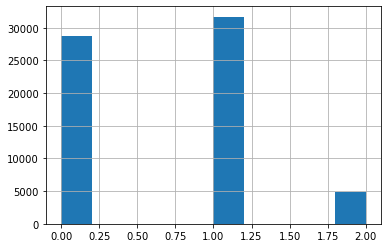

In [45]:
y_test.hist()
plt.show()

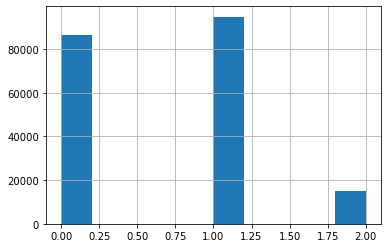

In [46]:
y_train.hist()
plt.show()

Jak widać rozkład etykiety jest tożsamy w obu próbkach, reprezentatywność zachowana.

# Budowa modelu

In [47]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
proba = xgb.predict_proba(X_test)
pred = xgb.predict(X_test)

C:\Users\laura\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\laura\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
roc_auc_score(y_test, proba, average="weighted", multi_class="ovr")

0.7511805746134209

# Wnioski

* Przeprowadzając preprocessing na danych treningowych i testowych, osiągneliśmy podobne rezultaty w kwestii na przykład brakujących danych, czy też rozkładów zmiennych kodowanych.
* Braków danych praktycznie nie było, pojedyncze przypadki po prostu usunęliśmy (nie ma sensu stosować metod imputacji dla 1-2 rekordów na 420000) - reprezentatywność danych się nie zmniejszy
* Po przeanalizowaniu wyników modelu, zdecydowaliśmy się na zachowanie informacji o dwóch kategoriach `main_category` i nowoutworzona `second_category`, gdyż model lepiej predyktował zmienną celu w oparciu o te dodatkowe informacje i nie ulegał przeuczeniu.
* Po przetworzeniu danych, postanowiliśmy zbudować model w oparciu o algorytm Gradient Boost.
* W przypadku zbudowanego modelu osiągnęliśmy niezłe wyniki, które sprawdziliśmy metryką AUC ROC (polem pod krzywą ROC)

## Walidacja:

Tak jak zostało to powiedziane wcześniej, nasza grupa będzie pracować na danych do walidacji: `X_val`, `y_val` (dla ułatwienia preprocessingu połączymy obie tabelki). Aby zachować jednolitość, preprocessing ;przerpowadzimy e ten sam sposób co druga gruoa.

In [49]:
data = X_val.join(y_val)

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65385 entries, 308699 to 99832
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   categories              65385 non-null  object 
 1   pay_option_on_delivery  65385 non-null  int64  
 2   pay_option_transfer     65385 non-null  int64  
 3   seller                  65385 non-null  object 
 4   it_is_allegro_standard  65385 non-null  int64  
 5   it_quantity             65385 non-null  int64  
 6   it_is_brand_zone        65385 non-null  int64  
 7   it_seller_rating        65385 non-null  int64  
 8   it_location             65385 non-null  object 
 9   main_category           65385 non-null  object 
 10  second_category         65385 non-null  object 
 11  price                   65385 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 8.5+ MB


Podobnie jak w przypadku drugiej grupy, w naszym wypadku nie ma braków danych oznaczonych nullami/NA.

In [51]:
x = []
for col in data:
    x.append(data[data[col].isin(["?", -1, "Unknown", "unknown", ""])].shape[0])

In [52]:
x

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [53]:
data[data["it_location"].isin(["?", -1, "Unknown", "unknown", ""])]

,categories,pay_option_on_delivery,pay_option_transfer,seller,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,second_category,price
189216,"['Książki i Komiksy', 'Książki naukowe i popul...",0,0,Vampirburzum,0,0,0,1379,?,Książki i Komiksy,Książki naukowe i popularnonaukowe,170.0


W naszym wypadku, jest tylko 1 rekord w którym mamy brak danych, w kolumnie `it_location`. Jest on oznaczony znakiem "?". Jako, że to 1 rekord z 65385 również go usuniemy.

In [54]:
data = data[data["it_location"] != "?"]

In [55]:
data[data["it_location"].isin(["?", -1, "Unknown", "unknown", ""])]

,categories,pay_option_on_delivery,pay_option_transfer,seller,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,second_category,price


Tak jak druga grupa, usuniemy kolumnę `seller`, gdyż przy identyfikacji `price` o wiele bardziej obchodzić nas będzie `rating` sprzedającego niż tylko jego pseudonim.

In [56]:
data.drop("seller", axis = 1, inplace = True)

Sprawdzamy decyle w kolumnie `it_quantity`, aby ją encodować na 4 kategorie...

In [57]:
np.percentile(data["it_quantity"], [i for i in range(10, 110, 10)])

array([0.0000e+00, 2.0000e+00, 8.0000e+00, 2.2000e+01, 6.2000e+01,
       1.6000e+02, 6.8700e+02, 9.5500e+02, 9.9800e+02, 9.9999e+04])

Wartości drugiej grupy:  
`array([0.0000e+00, 2.0000e+00, 8.0000e+00, 2.2000e+01, 6.2000e+01,
       1.6600e+02, 6.7300e+02, 9.5500e+02, 9.9800e+02, 9.9999e+04])`

In [58]:
data["it_quantity"] = data["it_quantity"].apply(encode_quant)

... decyle w kolumnie `it_seller_rating`, aby ją encodować na 3 kategorie...

In [59]:
np.percentile(data["it_seller_rating"], [i for i in range(10, 110, 10)])

array([   306. ,    933. ,   2040. ,   3621.2,   5997. ,   9534.8,
        14862. ,  24932. ,  49489. , 292074. ])

Wartości drugiej grupy:  
`array([   309. ,    951. ,   2067.4,   3663. ,   6066. ,   9653. ,
        14912. ,  25139. ,  49591. , 292073. ])`

In [60]:
data["it_seller_rating"] = data["it_seller_rating"].apply(seller_rating_encode)

...oraz decyle w kolumnie `price`, aby ją encodować na 3 kategorie.

In [61]:
np.percentile(data["price"], [i for i in range(10, 110, 10)])

array([3.490e+00, 6.990e+00, 1.199e+01, 1.800e+01, 2.500e+01, 3.599e+01,
       5.490e+01, 8.990e+01, 1.690e+02, 4.600e+04])

Wartości drugiej grupy:  
`array([3.450e+00, 6.990e+00, 1.190e+01, 1.799e+01, 2.500e+01, 3.549e+01,
       5.400e+01, 8.900e+01, 1.690e+02, 1.190e+05])`

In [62]:
data["price"] = data["price"].apply(encode_price)

In [63]:
encoder = TargetEncoder()
encoder.fit(df["it_location"], df["price"])
data["location_encoded"] = encoder.transform(data["it_location"])
data.drop("it_location", axis = 1, inplace = True)

In [64]:
np.percentile(data["location_encoded"], [i for i in range(10, 110, 10)])

array([  26.88783788,   43.10930789,   56.23198641,   63.91588251,
         68.27079125,   76.77800573,   84.82662577,   90.26982338,
        107.85636553, 3895.55877314])

Wartości drugiej grupy:  
`array([   26.80087719,    42.4993228 ,    55.88924915,    63.91588251,
          68.27079125,    76.77800573,    84.82662577,    90.26982338,
         108.31573248, 19748.19493513])`

In [65]:
data["location_encoded"] = data["location_encoded"].apply(encode_location_enc)

One-Hot Encoding `categories` względem dwóch pierwszych kategorii

In [66]:
data.reset_index(drop = True, inplace = True)

In [67]:
ohe_main = OneHotEncoder()
ohe_main.fit(pd.DataFrame(df["main_category"]))
main_category = pd.DataFrame(ohe_main.transform(pd.DataFrame(data["main_category"])).toarray())
main_category.columns = ohe_main.get_feature_names(["main_category"])

data = data.join(main_category)

ohe_sec = OneHotEncoder()
ohe_sec.fit(pd.DataFrame(df["second_category"]))
second_category = pd.DataFrame(ohe_sec.transform(pd.DataFrame(data["second_category"])).toarray())
second_category.columns = ohe_sec.get_feature_names(["second_category"])

data = data.join(second_category)

data.drop(["second_category", "main_category"], axis = 1, inplace = True)
data.drop('categories', axis = 1, inplace = True)

C:\Users\laura\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\laura\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Po skończeniu preprocessingu wróćmy do postaci `X_val`, `y_val`.

In [68]:
y_val = data["price"]
X_val = data.drop("price", axis = 1)

Ponieważ budowanie modelu nie było częścią obowiązkową, walidacja tej części zostanie pominięta. 

# Wnioski

* Większość pracy jest poprawna i wyniki na danych treningowych i walidacyjnych są zbliżone.
* Powinien zostać zachowany podział między danymi do budowy a danymi do walidacji, nie powinny mieć ze sobą styczności.